In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csc_matrix as csc
import pandas as pd
pd.options.display.float_format = '{:,.6f}'.format
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    roc_auc_score,
    log_loss,
    confusion_matrix
)
from sklearn.preprocessing import minmax_scale
import time
import matplotlib.pyplot as plt
FONT_SIZE = 24
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = FONT_SIZE
plt.rcParams['legend.fontsize'] = FONT_SIZE
plt.rcParams['xtick.labelsize'] = FONT_SIZE
plt.rcParams['ytick.labelsize'] = FONT_SIZE
%config InlineBackend.figure_format ='retina'
import itertools
from constants import (SEED, EPSILON, EVENT_THRESHOLD, DEFAULT_K, DEFAULT_THRESHOLD,  UX_CONSTANTS, LOG_DIR, 
                       DATA_DIR, TEST_DATA_PATH, DATA_OCT, DATA_NOV, USECOLS, USER, ITEM, RATING, PREDICTION)
from utilities.ms_evaluation import (rmse, auc, logloss, precision_at_k, recall_at_k, ndcg_at_k, map_at_k, mae, rsquared, exp_var)

In [2]:
NAME = r'BasicMatrixFactorization'
Y_HAT_PATH = DATA_DIR+r'/'+NAME+r'-y_hat.npz'
TEST_RESULTS_PATH = LOG_DIR+'\\'+NAME+'\\test-results.csv'
SKL = "(calculated using sklearn.metrics on non-zero values of sparse matrices)"
SPA = "(calculated using CSC sparse matrix operations)"
MSE = "(calculated using the Microsoft Evaluation method)"
ux_constants = pd.Series(pd.read_csv(UX_CONSTANTS, index_col=0, squeeze=True, header=None), dtype='float32')
POSITIVE_ABOVE = ux_constants['positive_above']

In [3]:
start_time = time.time()
log = pd.Series(dtype='float64')
y_hat = sp.load_npz(Y_HAT_PATH) 
y = sp.load_npz(TEST_DATA_PATH)
assert y_hat.shape == y.shape, 'The shape of Y and Y_hat must match, otherwise they are not comparable.'
print(f"Shape of the matrices: {y.shape}")
print("Number of non-zero values:")
print(f"Y: {y.nnz:8,}")
print(f"Ŷ: {y_hat.nnz:8,}")

Shape of the matrices: (177592, 44780)
Number of non-zero values:
Y:  552,255
Ŷ:  552,255


In [4]:
def sparse_to_dense(matrix):
    matrix = matrix.todok()
    dense = []
    rows,cols = matrix.nonzero()
    for row,col in zip(rows,cols):
        dense.append([row,col,matrix[row,col]])
    return dense

In [5]:
df_true = pd.DataFrame(data=sparse_to_dense(y),columns=[USER, ITEM, RATING])
df_pred = pd.DataFrame(data=sparse_to_dense(y_hat),columns=[USER, ITEM, PREDICTION])
# Usually, the CSC is used when there are more rows than columns. (If there are more columns, use CSR instead.)
y_hat = y_hat.tocsc()
y = y.tocsc()
y_nz = np.array(y[y.nonzero()]).reshape(-1)
y_hat_nz = np.array(y_hat[y_hat.nonzero()]).reshape(-1)

# Standard metrics

### Mean Square Error

In [6]:
mse_spa = csc.sum(csc.power(y_hat-y,2))/y.nnz
mse_skl = mean_squared_error(y_nz,y_hat_nz)
print(f"Mean Square Error: {mse_spa} {SPA}")
print(f"Mean Square Error: {mse_skl} {SKL}")
print('Note: The smaller the better.')
log["mse"]=mse_spa

Mean Square Error: 1.3106135299816208 (calculated using CSC sparse matrix operations)
Mean Square Error: 1.3106136322021484 (calculated using sklearn.metrics on non-zero values of sparse matrices)
Note: The smaller the better.


### Root Mean Square Error

In [7]:
rmse_spa = np.sqrt(mse_spa)
rmse_skl = np.sqrt(mse_skl)
rmse_mse = rmse(df_true,df_pred)
print(f"Root Mean Square Error: {rmse_spa} {SPA}")
print(f"Root Mean Square Error: {rmse_skl} {SKL}")
print(f"Root Mean Square Error: {rmse_mse} {MSE}")
print('Note: The smaller the better.')
log["rmse"]=rmse_spa

Root Mean Square Error: 1.14482030466865 (calculated using CSC sparse matrix operations)
Root Mean Square Error: 1.1448203325271606 (calculated using sklearn.metrics on non-zero values of sparse matrices)
Root Mean Square Error: 1.14482033897321 (calculated using the Microsoft Evaluation method)
Note: The smaller the better.


### Mean Absolute Error

In [8]:
mae_spa = csc.sum(abs(y_hat-y))/y.nnz
mae_skl = mean_absolute_error(y_nz,y_hat_nz)
mae_mse = mae(df_true,df_pred)
print(f"Mean Absolute Error: {mae_spa} {SPA}")
print(f"Mean Absolute Error: {mae_skl} {SKL}")
print(f"Mean Absolute Error: {mae_mse} {MSE}")
print('Note: The smaller the better.')
log["mae"]=mae_spa

Mean Absolute Error: 0.58932699794479 (calculated using CSC sparse matrix operations)
Mean Absolute Error: 0.5893269181251526 (calculated using sklearn.metrics on non-zero values of sparse matrices)
Mean Absolute Error: 0.5893270429255207 (calculated using the Microsoft Evaluation method)
Note: The smaller the better.


### R²

In [9]:
r2_skl = r2_score(y_nz,y_hat_nz)
r2_mse = rsquared(df_true,df_pred)
print(f"Coefficient of determination (R\u00B2): {r2_skl} {SKL}")
print(f"Coefficient of determination (R\u00B2): {r2_mse} {MSE}")
print("Note: The closer to 1 the better.")
log["r-squared"]=r2_skl

Coefficient of determination (R²): -17.554057961110132 (calculated using sklearn.metrics on non-zero values of sparse matrices)
Coefficient of determination (R²): -17.55405697044492 (calculated using the Microsoft Evaluation method)
Note: The closer to 1 the better.


### Explained variance

In [10]:
exp_var_skl = explained_variance_score(y_nz,y_hat_nz)
exp_var_mse = exp_var(df_true,df_pred)
print(f"Explained variance: {exp_var_skl} {SKL}")
print(f"Explained variance: {exp_var_mse} {MSE}")
print("Note: The closer to 1 the better.")
log["exp_var"]=exp_var_skl

Explained variance: -16.634532928466797 (calculated using sklearn.metrics on non-zero values of sparse matrices)
Explained variance: -16.634527743470144 (calculated using the Microsoft Evaluation method)
Note: The closer to 1 the better.


### Arear Under Curve (AUC) - integral area under the receiver operating characteristic curve

In [11]:
# For AUC and logloss we need binary ratings and predictions in the [0,1] range
df_true_bin = df_true.copy()
df_true_bin[RATING] = df_true_bin[RATING].apply(lambda x: 1 if x > POSITIVE_ABOVE else 0)
df_pred_bin = df_pred.copy()
df_pred_bin[PREDICTION] = minmax_scale(df_pred_bin[PREDICTION].astype(float))

In [12]:
auc_mse = auc(df_true_bin,df_pred_bin)
print(f"Arear Under Curve (AUC): {auc_mse} {MSE}")
print("Note: The closer to 1 the better. 0.5 indicates an uninformative classifier")
log["auc"]=auc_mse

Arear Under Curve (AUC): 0.5017639967707804 (calculated using the Microsoft Evaluation method)
Note: The closer to 1 the better. 0.5 indicates an uninformative classifier


### Logistic loss (logloss)

In [13]:
logloss_mse = logloss(df_true_bin,df_pred_bin)
print(f"Logistic loss (logloss): {logloss_mse} {MSE}")
print("Note: The closer to 0 the better.")
log["logloss"]=logloss_mse

Logistic loss (logloss): 0.8076623344576784 (calculated using the Microsoft Evaluation method)
Note: The closer to 0 the better.


### Precision @ K

In [14]:
precision_at_k_mse = precision_at_k(df_true,df_pred)
print(f"Precision @ {DEFAULT_K}: {precision_at_k_mse} {MSE}")
print("Note: The closer to 1 the better.")
log[f"precision-at-{DEFAULT_K}"]=precision_at_k_mse

Precision @ 10: 0.34191752705560396 (calculated using the Microsoft Evaluation method)
Note: The closer to 1 the better.


### Recall @ K

In [15]:
recall_at_k_mse = recall_at_k(df_true,df_pred)
print(f"Recall @ {DEFAULT_K}: {recall_at_k_mse} {MSE}")
print("Note: The closer to 1 the better.")
log[f"recall-at-{DEFAULT_K}"]=recall_at_k_mse

Recall @ 10: 0.9668412602660089 (calculated using the Microsoft Evaluation method)
Note: The closer to 1 the better.


### normalized Discounted Cumulative Gain

In [16]:
ndcg_mse = ndcg_at_k(df_true,df_pred)
print(f"normalized Discounted Cumulative Gain (nDCG@{DEFAULT_K}): {ndcg_mse} {MSE}")
print("Note: The closer to 1 the better.")
log[f"ndcg-at-{DEFAULT_K}"]=ndcg_mse

normalized Discounted Cumulative Gain (nDCG@10): 1.0 (calculated using the Microsoft Evaluation method)
Note: The closer to 1 the better.


### mAP (mean Average Precision) 

In [17]:
map_mse = map_at_k(df_true,df_pred)
print(f"mean Average Precision (mAP@{DEFAULT_K}): {map_mse} {MSE}")
print("Note: The closer to 1 the better.")
log[f"map-at-{DEFAULT_K}"]=map_mse

mean Average Precision (mAP@10): 0.9668412602660089 (calculated using the Microsoft Evaluation method)
Note: The closer to 1 the better.


## Confusion matrix

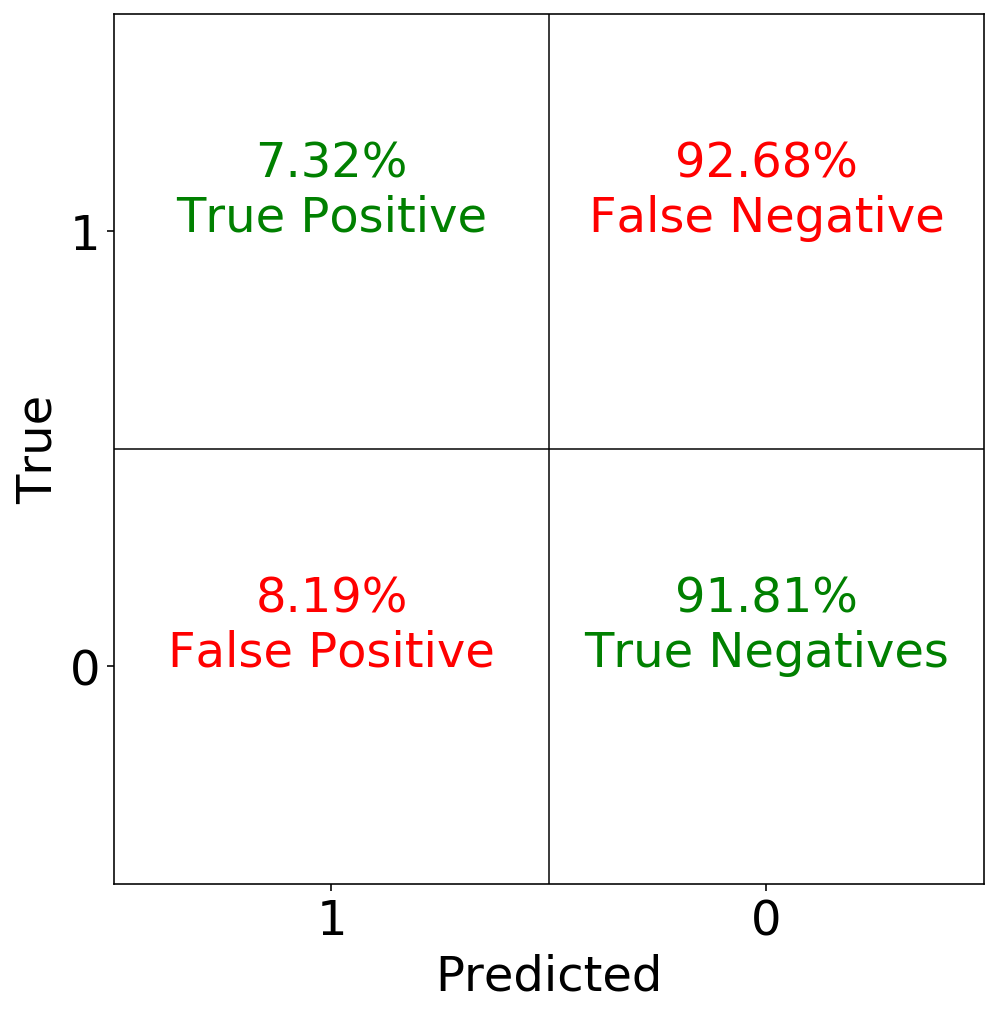

In [18]:
conf_mat = confusion_matrix(
    [1 if x > POSITIVE_ABOVE  else 0 for x in y_nz],
    [1 if x > POSITIVE_ABOVE  else 0 for x in y_hat_nz],  
    labels=[1,0])
conf_mat = np.round(conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis],4)*100
log["true_positive"]=f"{conf_mat[0,0]:.2f}%"
log["false_negative"]=f"{conf_mat[0,1]:.2f}%"
log["false_positive"]=f"{conf_mat[1,0]:.2f}%"
log["true_negative"]=f"{conf_mat[1,1]:.2f}%"

descriptions = np.array([["True Positive", "False Negative"], ["False Positive", "True Negatives"]])
colors = np.array([["green", "red"], ["red", "green"]])

plt.imshow([[0,0],[0,0]], interpolation='nearest', cmap=plt.cm.Greys)
for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])): 
    plt.text(j, i, format(conf_mat[i, j], ".2f")+'%\n' + descriptions[i, j], horizontalalignment="center", color=colors[i,j])
plt.axhline(y=0.5, xmin=0, xmax=1, color="black", linewidth=0.75)
plt.axvline(x=0.5, ymin=0, ymax=1, color="black", linewidth=0.75)
plt.ylabel('True')
plt.xlabel('Predicted')
# plt.title("Confusion Matrix")
plt.xticks([0,1], [1,0])
plt.yticks([0,1], [1,0])
plt.show()

In [19]:
log

mse                 1.310614
rmse                1.144820
mae                 0.589327
r-squared         -17.554058
exp_var           -16.634533
auc                 0.501764
logloss             0.807662
precision-at-10     0.341918
recall-at-10        0.966841
ndcg-at-10          1.000000
map-at-10           0.966841
true_positive          7.32%
false_negative        92.68%
false_positive         8.19%
true_negative         91.81%
dtype: object

In [20]:
print(f"Elapsed time: {time.time()-start_time:.2f} seconds")

Elapsed time: 178.44 seconds


In [21]:
log.to_csv(TEST_RESULTS_PATH, index = True, header=False)
print(f"Results saved to: {TEST_RESULTS_PATH}")

Results saved to: C:\TensorLogs\BasicMatrixFactorization\test-results.csv
